# Демонстрация автоматического отбора признаков с помощью Permutation Importance

## Структура ноутбука:

- Применение библиотеки Permutation Importance для задач мультиклассификации
    * Проверка Permutation Importance на доступных алгоритмах
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib) на CatBoostClassifier   

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PermutationSelection, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.4


In [5]:
import numpy as np
np.__version__

'1.22.4'

In [6]:
import scipy
scipy.__version__

'1.8.1'

In [7]:
# eli5==0.13.0

# Для мультиклассовой задачи

In [8]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1500, n_features=25, n_informative=8, n_redundant=17, n_classes=3, random_state=42)
sample = pd.DataFrame(X)
sample.columns = [f'feature_{i}' for i in range(len(sample.columns))]


sample['target'] = y

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1500, 26)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,target
0,0.534065,2.522191,0.142878,2.921343,-0.837638,-3.631808,-1.386599,-0.624858,1.923359,-3.754648,...,4.320680,-2.841549,-0.615687,-2.638303,-0.941292,2.561901,1.411905,2.305033,-1.411519,0
1,1.912064,3.015669,-4.114627,-1.720778,-1.049952,-3.575342,-0.719276,4.859142,-1.959112,5.192894,...,1.411251,-2.774986,1.396434,0.908956,5.203906,0.584113,4.710460,-3.295091,-1.562306,1


In [9]:
num_columns = sample.drop(columns='target').columns.tolist()

cat_columns = [
]

features = num_columns+cat_columns

target = ['target']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    sample[features],
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [11]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

In [12]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_val)

# 1. Использование библиотеки Auto Permutation

#### Проверка на нескольких моделях 

* Для выбора оптимального алгоритма, можно запустить метод на различных моделях бустинга, деревьев. Задаются словари параметров, листы со словарями и названием моделей. 

In [13]:
# Определение стандартных гиперпараметров моделей и список моделей

params_xgb = {
    'eta':0.01,
    'n_estimators':500,
    'subsample':0.9,
    'max_depth':6,
    'objective':'multi:softmax',
    'num_class':3,
    'n_jobs':-1,
    'random_state':42,
    'eval_metric':'auc'}

params_ctb = {
    'learning_rate':0.01,
    'iterations':500,
    'subsample':0.9,
    'depth':6,
    'loss_function':'Logloss',
    'objective':'MultiClass',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'MultiClass',
    'bootstrap_type':'MVS',
    'verbose':0}

params_lgb = {
    'learning_rate':0.01,
    'n_estimators':500,
    'subsample':0.9,
    'max_depth':6,
    'objective':'multiclass',
    'num_class': 3,
    'n_jobs':-1,
    'random_state':42,
    'metric':'auc_mu'}

params_dt = {
             'max_depth':6,
             'random_state':42}

params_rf = {
             'max_depth':6,
             'random_state':42,
             'n_estimators':500}

params_list = [params_xgb, 
               params_ctb, 
               params_lgb, 
               params_dt, 
               params_rf
              ]

models_list = ['xgboost', 
               'catboost', 
               'lightboost', 
               'decisiontree', 
               'randomforest'
              ] 

### 1.1. Определяем класс PermutationSelection, куда передаем список из словарей параметров, список моделей, а также задаем тип задачи: "classification"/"multiclassification"/"regression"

* Далее запускаем метод обучения fit, куда передаем тренировочное множество (фолд из тренировочного множества, при больших выборках), и целевую переменную.


* Далее запускае метод calculate_permutation. Это основной метод для расчета метрик при перемешивании факторов. В метод передается тестовое множество (независимый фолд из тренировочного множества, при больших выборках), целевую переменную для тестового множества, количество перемешиваний фактора, способ Permutation Importance ("eli5"/"sklearn"/"kib"). Для более подробного описания метода, можно вызвать функцию shift+tab


* Все запускается циклом, для отбора более быстрого оптимального алгоритма.
    * Запуск требуется по желанию, если есть независимые фолды маленьких размеров.
    * Данный цикл является примером работы на всех доступных алгоритмах.

In [14]:
# Прописываем необходимую функцию для метрики

from sklearn.metrics import f1_score

def f1_macro(ytr,ypred):
    return f1_score(ytr,ypred,average='macro')

In [15]:
# Применение самописной библиотеки Permutation Importance (kib)

features_dict=dict()

for i in range(len(params_list)):
    
    perm_imp = PermutationSelection(
        model_type=models_list[i], 
        model_params=params_list[i], 
        task_type='multiclassification')
    
    perm_imp.fit(
        X_train=new_X_train,
        y_train=y_train)
    
    perm_imp.calculate_permutation(
        X_test=new_X_valid, 
        y_test=y_val,
        n_iter=5,
        permute_type='kib',
        n_jobs=-1,
        metric=f1_macro,
        higher_is_better=True)
    
    
    print('Модель: ', models_list[i],'\n')
    features_dict[models_list[i]] = perm_imp.select_features()
    print()

Расчет Permutation Importance на Train


100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 90.41it/s]


Расчет Permutation Importance на Test


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 7922.40it/s]


Модель:  xgboost 

26 признаков было до Permutation Importance 

20 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 15999.40it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 12615.91it/s]

Модель:  catboost 

26 признаков было до Permutation Importance 

24 признаков после Permutation Importance от kib



Расчет Permutation Importance на Train


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1649.45it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 10383.92it/s]


Модель:  lightboost 

26 признаков было до Permutation Importance 

23 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 10979.85it/s]


Расчет Permutation Importance на Test


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 7536.41it/s]


Модель:  decisiontree 

26 признаков было до Permutation Importance 

22 признаков после Permutation Importance от kib

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 13763.97it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 19290.98it/s]


Модель:  randomforest 

26 признаков было до Permutation Importance 

24 признаков после Permutation Importance от kib



* После обучения моделей получаем словари факторов для каждого из алгоритмов. Также можно отследить скорость обучения и выбрать подходящий для нас алгоритм

In [16]:
features_dict

{'xgboost': ['feature_24',
  'feature_23',
  'feature_3',
  'feature_21',
  'feature_7',
  'feature_9',
  'feature_8',
  'feature_1',
  'feature_2',
  'feature_11',
  'feature_15',
  'feature_13',
  'feature_20',
  'feature_12',
  'feature_10',
  'feature_0',
  'feature_18',
  'feature_5',
  'feature_22',
  'feature_6'],
 'catboost': ['feature_23',
  'feature_21',
  'feature_3',
  'feature_24',
  'feature_9',
  'feature_1',
  'feature_7',
  'feature_18',
  'feature_11',
  'feature_20',
  'feature_15',
  'feature_8',
  'feature_2',
  'feature_14',
  'feature_0',
  'feature_4',
  'feature_12',
  'feature_13',
  'feature_10',
  'feature_5',
  'feature_6',
  'feature_17',
  'feature_22',
  'feature_16'],
 'lightboost': ['feature_23',
  'feature_24',
  'feature_21',
  'feature_3',
  'feature_7',
  'feature_13',
  'feature_10',
  'feature_15',
  'feature_1',
  'feature_9',
  'feature_2',
  'feature_8',
  'feature_20',
  'feature_11',
  'feature_12',
  'feature_0',
  'feature_18',
  'feature_

* После анализа цикла, выбираем лучший алгоритм относительно скорость / качество. В нашем случае выбор выберем catboost и покажем на его примере.

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### 2.1. Задаем класс PermutationSelection. Передаем выборанный нами алгоритм, словарь параметров алгоритмы, а также тип решаемой задачи (покажем на примере catboost)

In [17]:
models_list[1]

'catboost'

In [18]:
params_list[1]

{'learning_rate': 0.01,
 'iterations': 500,
 'subsample': 0.9,
 'depth': 6,
 'loss_function': 'Logloss',
 'objective': 'MultiClass',
 'thread_count': -1,
 'random_state': 42,
 'eval_metric': 'MultiClass',
 'bootstrap_type': 'MVS',
 'verbose': 0}

In [19]:
perm_imp = PermutationSelection(
    model_type=models_list[1], 
    model_params=params_list[1], 
    task_type='multiclassification')

### 2.2. Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются тренировочная выборка (фолд из тренировочной выборки), целевая переменная, список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [20]:
fi, fi_rank, depth_features, rank_features = perm_imp.depth_analysis(new_X_train, y_train, features,5)

  0%|          | 0/5 [00:00<?, ?it/s]

Количество признаков до отбора: 25
Количество признаков после mean importance относительно глубины: 25
Количество признаков после mean rank относительно глубины: 25


In [21]:
# Таблица важностей признаков относительно глубины

fi

,importance_depth_1,importance_depth_2,importance_depth_3,importance_depth_4,importance_depth_5,mean_importance,mean_rank
feature_21,24.880141,18.430489,13.962910,11.869609,10.036544,15.835939,0.079105
feature_24,22.761265,15.144058,12.374216,10.940697,10.572092,14.358466,0.076393
feature_3,16.830716,14.158327,11.316908,11.414635,9.914086,12.726934,0.072815
feature_9,17.615793,11.127009,9.216353,7.037624,6.973703,10.394096,0.069373
feature_23,1.110387,5.335248,6.874064,7.630966,7.507022,5.691537,0.063313
feature_13,5.455899,4.616417,4.766653,5.141569,4.759738,4.948055,0.062719
feature_2,2.914684,4.148669,4.140146,4.279986,4.430403,3.982778,0.058161
feature_1,0.406600,2.864402,4.114742,4.651006,5.412149,3.489780,0.052100
feature_7,0.841096,3.006042,3.948499,4.485059,4.958543,3.447848,0.051735
feature_20,0.979087,3.871674,3.890513,3.928545,3.623643,3.258692,0.048293


In [22]:
# Таблица рангов признаков относительно глубины

fi_rank

,rank_depth_1,rank_depth_2,rank_depth_3,rank_depth_4,rank_depth_5,mean_rank
index,,,,,,
feature_21,0.090909,0.076923,0.076923,0.076923,0.073846,0.079105
feature_24,0.086580,0.073846,0.073846,0.070769,0.076923,0.076393
feature_3,0.077922,0.070769,0.070769,0.073846,0.070769,0.072815
feature_9,0.082251,0.067692,0.067692,0.064615,0.064615,0.069373
feature_23,0.051948,0.064615,0.064615,0.067692,0.067692,0.063313
feature_13,0.073593,0.061538,0.061538,0.061538,0.055385,0.062719
feature_2,0.069264,0.058462,0.058462,0.052308,0.052308,0.058161
feature_1,0.038961,0.046154,0.055385,0.058462,0.061538,0.052100
feature_7,0.043290,0.049231,0.052308,0.055385,0.058462,0.051735


In [23]:
# Обновляем признаки после отбора по важностям или рангу относительно глубины

new_num_columns = list(filter(lambda x: x in num_columns, depth_features))
new_cat_columns = list(filter(lambda x: x in cat_columns, depth_features))

# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [24]:
%%time

prep_pipe = base_pipe(
    num_columns=new_num_columns, 
    cat_columns=new_cat_columns, 
    kind='all')

prep_pipe.fit(X_train[depth_features], y_train)

new_X_train = prep_pipe.transform(X_train[depth_features])
new_X_valid = prep_pipe.transform(X_val[depth_features])

perm_imp.fit(
    X_train=new_X_train,
    y_train=y_train)

CPU times: user 18.3 s, sys: 415 ms, total: 18.7 s
Wall time: 1.75 s


### 3.1 От Sklearn

In [25]:
%%time

# От Sklearn

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='sklearn',
    n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 166 ms, sys: 22.1 ms, total: 188 ms
Wall time: 625 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_23,0.063429,0.048593
feature_24,0.066540,0.045926
feature_3,0.049143,0.044741
feature_21,0.042857,0.043407
feature_1,0.033841,0.034667
feature_9,0.022095,0.026815
feature_2,0.026222,0.021037
feature_15,0.014286,0.018519
feature_18,0.013587,0.018519


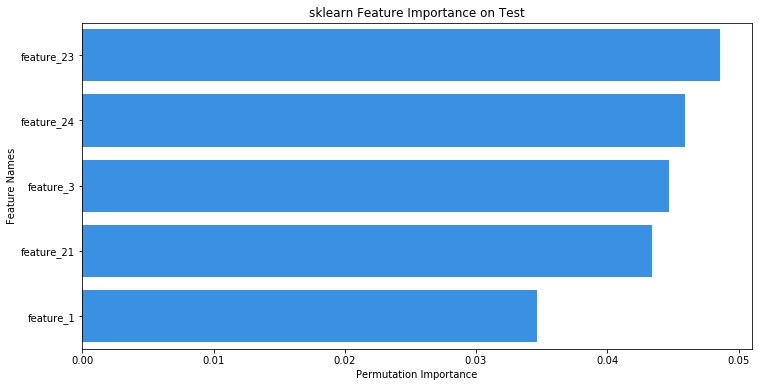

In [26]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

perm_imp.permutation_plot(top=5, figsize=(12,6))

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [27]:
perm_imp.select_features()

26 признаков было до Permutation Importance 

22 признаков после Permutation Importance от sklearn


['feature_23',
 'feature_24',
 'feature_3',
 'feature_21',
 'feature_1',
 'feature_9',
 'feature_2',
 'feature_15',
 'feature_18',
 'feature_7',
 'feature_20',
 'feature_12',
 'feature_11',
 'feature_0',
 'feature_13',
 'feature_10',
 'feature_4',
 'feature_6',
 'feature_17',
 'feature_14',
 'feature_8',
 'feature_22']

### 3.2 От Eli5

In [28]:
%%time

# От Eli5

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='eli5',
#   n_jobs=-1,
#   metric=roc_auc_score,
#   higher_is_better=True
)

CPU times: user 6.41 s, sys: 449 ms, total: 6.86 s
Wall time: 4 s


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_24,0.069143,0.051259
feature_21,0.039810,0.049333
feature_23,0.064190,0.048741
feature_3,0.045714,0.042370
feature_1,0.033016,0.033778
feature_9,0.026095,0.026815
feature_11,0.017270,0.020889
feature_15,0.014349,0.019556
feature_2,0.025905,0.017926


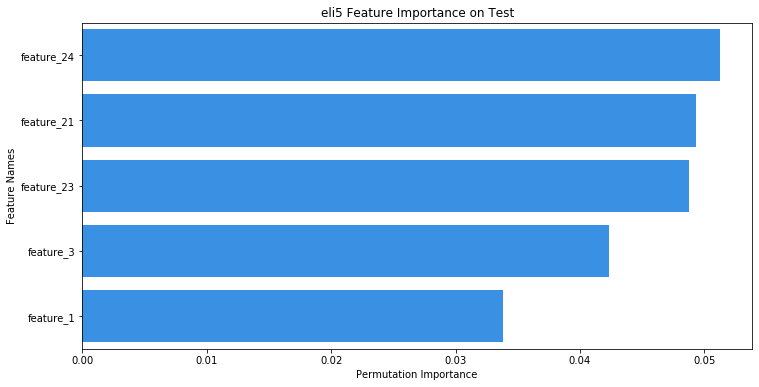

In [29]:
perm_imp.permutation_plot(top=5, figsize=(12,6))

In [30]:
perm_imp.select_features()

26 признаков было до Permutation Importance 

23 признаков после Permutation Importance от eli5


['feature_24',
 'feature_21',
 'feature_23',
 'feature_3',
 'feature_1',
 'feature_9',
 'feature_11',
 'feature_15',
 'feature_2',
 'feature_18',
 'feature_20',
 'feature_7',
 'feature_0',
 'feature_12',
 'feature_13',
 'feature_10',
 'feature_8',
 'feature_4',
 'feature_14',
 'feature_6',
 'feature_17',
 'feature_22',
 'feature_5']

### 3.3 Самописный permutation kib

In [31]:
%%time

# Самописный permutation

perm_imp.calculate_permutation(
    X_test=new_X_valid, 
    y_test=y_val,
    n_iter=15,
    permute_type='kib',
    n_jobs=-1,
    metric=f1_macro,
    higher_is_better=True)

Расчет Permutation Importance на Train


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 14053.08it/s]


Расчет Permutation Importance на Test


100%|████████████████████████████████████████| 26/26 [00:00<00:00, 15284.08it/s]


CPU times: user 165 ms, sys: 22.9 ms, total: 188 ms
Wall time: 756 ms


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_21,0.039808,0.052779
feature_23,0.062348,0.051297
feature_24,0.065072,0.050389
feature_3,0.047997,0.044950
feature_1,0.035096,0.037365
feature_9,0.024693,0.029728
feature_2,0.025048,0.023075
feature_7,0.020260,0.021976
feature_15,0.015428,0.020865


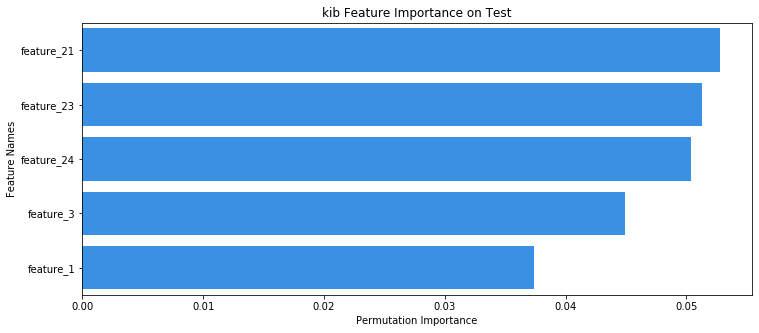

In [32]:
perm_imp.permutation_plot(top=5, figsize=(12,5))

In [33]:
perm_imp.select_features()

26 признаков было до Permutation Importance 

23 признаков после Permutation Importance от kib


['feature_21',
 'feature_23',
 'feature_24',
 'feature_3',
 'feature_1',
 'feature_9',
 'feature_2',
 'feature_7',
 'feature_15',
 'feature_11',
 'feature_18',
 'feature_20',
 'feature_0',
 'feature_12',
 'feature_10',
 'feature_13',
 'feature_4',
 'feature_14',
 'feature_8',
 'feature_17',
 'feature_6',
 'feature_5',
 'feature_22']